Device: cuda


100%|██████████| 2.04G/2.04G [01:37<00:00, 22.5MB/s]

Extracting files...



Epoch [4/5]: 100%|██████████| 9965/9965 [21:13<00:00,  7.82it/s, D_loss=0.0482, G_loss=21]


Pix2Pix Results


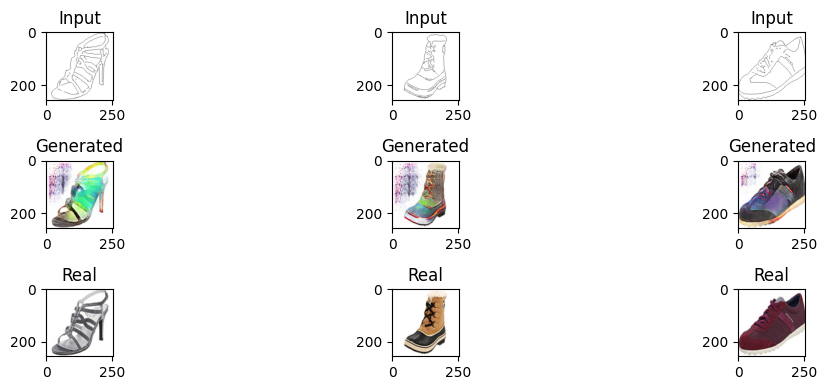

CNN Baseline Results


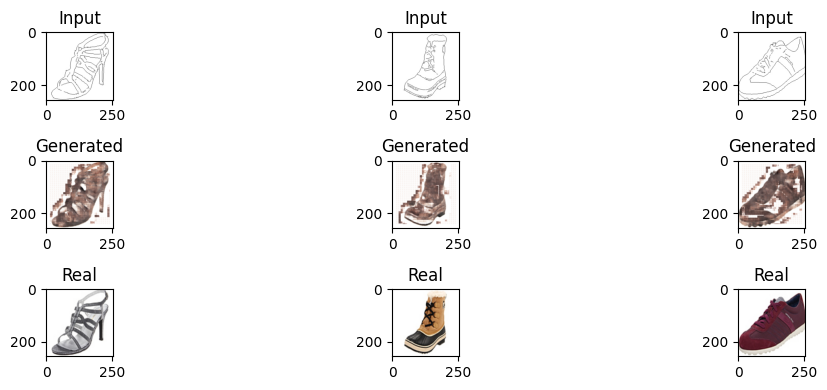

In [1]:
# =========================================================
# INSTALL (Colab only)
# =========================================================
# !pip install torch torchvision matplotlib kagglehub -q

# =========================================================
# IMPORTS
# =========================================================
import os, glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import kagglehub

# =========================================================
# DEVICE
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================================================
# TASK 1: DATASET PREPARATION
# =========================================================

# Download dataset
path = kagglehub.dataset_download("balraj98/edges2shoes-dataset")

class Edges2ShoesDataset(Dataset):
    def __init__(self, root_dir):
        self.files = sorted(glob.glob(root_dir + "/*.*"))
        self.transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        w, h = img.size
        inp = img.crop((0, 0, w//2, h))     # Edge
        tar = img.crop((w//2, 0, w, h))    # Real
        return self.transform(inp), self.transform(tar)

dataset = Edges2ShoesDataset(path + "/train")

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=4, shuffle=False)

# =========================================================
# TASK 2: U-NET GENERATOR
# =========================================================

class DownBlock(nn.Module):
    def __init__(self, in_c, out_c, norm=True):
        super().__init__()
        layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
        if norm:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UpBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x, skip):
        x = self.model(x)
        return torch.cat((x, skip), 1)

class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DownBlock(3,64,False)
        self.d2 = DownBlock(64,128)
        self.d3 = DownBlock(128,256)
        self.d4 = DownBlock(256,512)
        self.d5 = DownBlock(512,512)

        self.u1 = UpBlock(512,512)
        self.u2 = UpBlock(1024,256)
        self.u3 = UpBlock(512,128)
        self.u4 = UpBlock(256,64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128,3,4,2,1),
            nn.Tanh()
        )

    def forward(self,x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)

        u1 = self.u1(d5,d4)
        u2 = self.u2(u1,d3)
        u3 = self.u3(u2,d2)
        u4 = self.u4(u3,d1)

        return self.final(u4)

# =========================================================
# TASK 3: PATCHGAN DISCRIMINATOR
# =========================================================

class PatchGAN(nn.Module):
    def __init__(self):
        super().__init__()
        def block(in_c, out_c, norm=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
            if norm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.model = nn.Sequential(
            *block(6,64,False),
            *block(64,128),
            *block(128,256),
            *block(256,512),
            nn.Conv2d(512,1,4,1,1)
        )

    def forward(self,x,y):
        inp = torch.cat((x,y),1)
        return self.model(inp)

# =========================================================
# INITIALIZE PIX2PIX
# =========================================================
G = UNetGenerator().to(device)
D = PatchGAN().to(device)

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1  = nn.L1Loss()

opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))

lambda_L1 = 100
epochs = 5

# =========================================================
# TASK 4: TRAINING
# =========================================================
for epoch in range(epochs):
    loop = tqdm(train_loader)
    for inp, real in loop:
        inp, real = inp.to(device), real.to(device)

        # ---- Train Generator ----
        opt_G.zero_grad()
        fake = G(inp)
        pred_fake = D(inp,fake)
        valid = torch.ones_like(pred_fake)

        loss_GAN = criterion_GAN(pred_fake, valid)
        loss_L1  = criterion_L1(fake, real)
        loss_G = loss_GAN + lambda_L1 * loss_L1
        loss_G.backward()
        opt_G.step()

        # ---- Train Discriminator ----
        opt_D.zero_grad()

        pred_real = D(inp,real)
        loss_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        pred_fake = D(inp,fake.detach())
        loss_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        loss_D = (loss_real + loss_fake)/2
        loss_D.backward()
        opt_D.step()

        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(G_loss=loss_G.item(), D_loss=loss_D.item())

# =========================================================
# TASK 5: BASELINE CNN
# =========================================================

class CNNBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,64,4,2,1), nn.ReLU(),
            nn.Conv2d(64,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128,256,4,2,1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,2,1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64,3,4,2,1), nn.Tanh()
        )

    def forward(self,x):
        return self.decoder(self.encoder(x))

cnn = CNNBaseline().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=0.0002)
criterion = nn.L1Loss()

for epoch in range(5):
    for inp, real in train_loader:
        inp, real = inp.to(device), real.to(device)
        optimizer.zero_grad()
        output = cnn(inp)
        loss = criterion(output, real)
        loss.backward()
        optimizer.step()

# =========================================================
# PERFORMANCE COMPARISON (Visual)
# =========================================================

def show_results(model, loader):
    model.eval()
    inp, real = next(iter(loader))
    inp = inp.to(device)
    fake = model(inp).cpu().detach()

    plt.figure(figsize=(12,4))
    for i in range(3):
        plt.subplot(3,3,i+1)
        plt.imshow(inp[i].permute(1,2,0).cpu()*0.5+0.5)
        plt.title("Input")

        plt.subplot(3,3,i+4)
        plt.imshow(fake[i].permute(1,2,0)*0.5+0.5)
        plt.title("Generated")

        plt.subplot(3,3,i+7)
        plt.imshow(real[i].permute(1,2,0)*0.5+0.5)
        plt.title("Real")

    plt.tight_layout()
    plt.show()

print("Pix2Pix Results")
show_results(G, test_loader)

print("CNN Baseline Results")
show_results(cnn, test_loader)